In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.set_option("display.max_columns", 200)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate

In [2]:
df = pd.read_csv('housing_clean.csv', index_col=0)
df.shape

(2374, 99)

### Remove original columns that have been ordinalized

In [3]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_todrop')])

### Drop Features due to perfect multicollinearity
- Required for linear regression
- It also improves efficiency by having fewer features and interpretability (the feature importance scores will be split among all of the features with perfect multicollinearity).

In [4]:
multi_todrop = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt',
               '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'
               ]

In [5]:
df = df.drop(multi_todrop, axis = 1)

### Dummify Nominal Features
-  We will treat ordinal features as categorical features in this model to avoid running into issue with N/A (which was coded as -1 in the pre-processing step) when applying StandardScaler.
- For this dataset, this step needs to be done before train / test split. If done the other way around, X_train and X_test will end up with different number of columns

In [6]:
categ_nom = [
    'MSSubClass','BldgType','HouseStyle','SaleType','SaleCondition','MiscFeature',
    'Fence','GarageType','RoofStyle','RoofMatl','exterior_covering','MasVnrType',
    'MSZoning','Street','LotShape','LandContour','LotConfig','LandSlope','Neighborhood',
    'Alley','condition','Foundation','Utilities','Heating','CentralAir','MoSold','Electrical','QrtSold'
]

categ_nom_mlr = [col for col in df.columns if col.endswith('ordinal')] + categ_nom

In [7]:
# X_train = pd.get_dummies(X_train, columns=categ_nom_mlr, drop_first=True)
# X_test = pd.get_dummies(X_test, columns=categ_nom_mlr, drop_first=True)
df = pd.get_dummies(df, columns=categ_nom_mlr, drop_first=True)

### Perform Train / Test Split
- I used the data from 2006 to 2009 for training and 2010 for testing because it mimics a real-world scenario perfectly. It ensures my model is being evaluated on its ability to predict future, unseen data.
- I also dropped column 'YrSold' when training the data because the model might learn that homes sold in 2010 have a particular characteristic that is a direct result of the year itself (e.g., a general market trend or a single large event), rather than a true feature of the house. This makes the model less generalizable to future years. Features that have been derived from 'YrSold' such as 'age_at_sale', 'years_since_remod' and 'garage_age_derived' are directly related to the house, not the time of the market and it also avoids data leakage from the year itself.

In [8]:
X = df.drop(['SalePrice', 'PID', 'YrSold'], axis = 1)
y = df['SalePrice']

In [9]:
# Split the data into train and test based on the year the house was sold
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

X_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)].drop(['SalePrice', 'PID', 'YrSold'], axis = 1)
X_test = df.loc[df['YrSold'].astype(int) == 2010].drop(['SalePrice', 'PID', 'YrSold'], axis = 1)

y_train = df.loc[df['YrSold'].astype(int).between(2006, 2009)]['SalePrice']
y_test = df.loc[df['YrSold'].astype(int) == 2010]['SalePrice']

### Apply StandardScaler to all numerical features (except for categ_nom columns)

In [10]:
num_cols = X_train.select_dtypes(include="number").columns.tolist()

# numerical columns that should NOT be scaled (aka binary columns)
unscaled_num_cols = [col for col in num_cols if col in categ_nom_mlr]

# identify numerical features that SHOULD be scaled
num_cols_to_scale = [col for col in num_cols if col not in unscaled_num_cols]

In [11]:
# Standardize numerical features
scaler = StandardScaler()
X_train[num_cols_to_scale] = scaler.fit_transform(X_train[num_cols_to_scale])
X_test[num_cols_to_scale] = scaler.fit_transform(X_test[num_cols_to_scale])

### Check for Multicollinearity in Numerical Features

In [12]:
# --- 2. Check for Multicollinearity in Numerical Features ---
print("--- Checking for Multicollinearity (VIF) ---")

num_cols = X_train.select_dtypes(include="number").columns.tolist()

# Create a DataFrame with only the numerical features
X_numerical = X_train[num_cols]

# Add a constant term for the VIF calculation
X_numerical = sm.add_constant(X_numerical)

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(len(X_numerical.columns))]
vif_data = vif_data.sort_values(by='VIF', ascending=False)
vif_data = vif_data.round(2)

print(vif_data)
print("\n")
# A VIF value greater than 5 or 10 is often considered problematic.
# If VIF is high, it indicates multicollinearity.
# You can remove features with high VIF or use dimensionality reduction.

--- Checking for Multicollinearity (VIF) ---
               feature   VIF
1            GrLivArea  6.37
16          GarageCars  6.18
17          GarageArea  5.45
14        TotRmsAbvGrd  4.42
25         age_at_sale  3.49
4          OverallQual  2.90
10            FullBath  2.73
12        BedroomAbvGr  2.26
7          TotalBsmtSF  2.10
26   years_since_remod  2.07
11            HalfBath  1.86
27  garage_age_derived  1.60
5          OverallCond  1.57
15          Fireplaces  1.52
6           MasVnrArea  1.42
2          LotFrontage  1.38
13        KitchenAbvGr  1.37
8         BsmtFullBath  1.32
18          WoodDeckSF  1.24
3              LotArea  1.24
20       EnclosedPorch  1.20
19         OpenPorchSF  1.20
22         ScreenPorch  1.10
9         BsmtHalfBath  1.10
23            PoolArea  1.05
21           3SsnPorch  1.02
24             MiscVal  1.01
0                const  1.00




### Statistical inference by Statsmodels Package
- Use the 'statsmodels' package to fit a linear model with an intercept for the training data
- Use the p-value estimation of **statsmodels** slope coefficients and intercept to determine which coefficients are significant (up to 5% threshold)
- The t-statistic is a direct measure of a feature's significance. It is calculated by dividing the coefficient by its standard error. Interpretation: A large t-statistic (in absolute value) indicates that the feature's coefficient is significantly different from zero, meaning it's highly likely that the feature has a real impact on the target variable. The p-value you mentioned is derived directly from the t-statistic.




In [13]:
# need to convert bool columns to 0 and 1 other wise model = sm.OLS(np.log(y_train), x) won't work
# adjusted r-squared will only increase if a new feature genuinely improves the model more than would be expected
# by pure chance
# r-squared will always increases as you add more features even if those features are completely useless
bool_cols = X_train.select_dtypes(include="bool").columns.tolist()
X_train[bool_cols] = X_train[bool_cols].astype(int)

x = sm.add_constant(X_train)
model = sm.OLS(np.log(y_train), x)
#model = sm.OLS(y_train, x)
results = model.fit()
print(results.summary())

# sm.OLS(np.log(y_train), x)
# Training R-squared: 0.956
# Training Adj. R-squared: 0.948

# sm.OLS(y_train, x)
# Training R-squared: 0.943
# Training Adj. R-squared: 0.934

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     126.0
Date:                Thu, 18 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:22:33   Log-Likelihood:                 2323.4
No. Observations:                2086   AIC:                            -4031.
Df Residuals:                    1778   BIC:                            -2293.
Df Model:                         307                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [14]:
#pValues =results.pvalues

# Filter the p-values to find those that are significant (p < 0.05)
significant_p_values = results.pvalues[results.pvalues < 0.05]

# Get the list of column names (the index) from the filtered Series
significant_features = significant_p_values.index.tolist()

In [15]:
significant_features

['const',
 'GrLivArea',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'TotalBsmtSF',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea',
 'age_at_sale',
 'years_since_remod',
 'PavedDrive_ordinal_3',
 'PoolQC_ordinal_2',
 'PoolQC_ordinal_3',
 'PoolQC_ordinal_4',
 'PoolQC_ordinal_5',
 'Functional_ordinal_4',
 'Functional_ordinal_5',
 'Functional_ordinal_6',
 'Functional_ordinal_7',
 'Functional_ordinal_8',
 'KitchenQual_ordinal_2',
 'KitchenQual_ordinal_3',
 'KitchenQual_ordinal_4',
 'KitchenQual_ordinal_5',
 'BsmtQual_ordinal_5',
 'BsmtCond_ordinal_1',
 'BsmtExposure_ordinal_4',
 'BsmtFinType1_ordinal_1',
 'BsmtFinType1_ordinal_4',
 'BsmtFinType1_ordinal_5',
 'BsmtFinType1_ordinal_6',
 'BsmtFinType2_ordinal_4',
 'BsmtFinType2_ordinal_6',
 'ExterQual_ordinal_5',
 'ExterCond_ordinal_2',
 'ExterCond_ordinal_3',
 'ExterCond_ordinal_4',
 'ExterCond_ordinal_5',
 'MSSubClass_30',
 'MSSubClass_50',

### Setting up a baseline model before any tuning

* **Set a fair baseline:** Train a plain (untuned) model to get a reference R² you can compare against after tuning.
* **Reduce split luck:** Repeat the train/test split multiple times and **average** the R² so your baseline isn’t driven by a single “easy” or “hard” split.
* **Isolate variability:** Fix the model’s `random_state` so differences come from the **data splits**, not extra model randomness.
* **Make comparisons honest:** Report mean ± std of train/test R² from these repeats; tuning “wins” only if it beats this baseline by more than the noise.

In [16]:
model_baseline = LinearRegression()

In [17]:
model_baseline.fit(X_train, y_train)

LinearRegression()

In [18]:
# evaluate untuned / baseline model
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

# R2
r2_baseline_train = model_baseline.score(X_train, y_train)
r2_baseline_test = model_baseline.score(X_test, y_test)

print(f"Train R square: {r2_baseline_train:.4f}")
print(f"Test R square: {r2_baseline_test:.4f}")

# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms
rmse_baseline_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_baseline_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train Root Mean Squared Error: {rmse_baseline_train:.2f}")
print(f"Test Root Mean Squared Error: {rmse_baseline_test:.2f}")

Train R square: 0.9434
Test R square: 0.9183
Train Root Mean Squared Error: 17964.29
Test Root Mean Squared Error: 21240.14


In [19]:
# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Initialize baseline model
model = LinearRegression()

# Lists to store the scores and RMSE values
scores = []
rmse_values = []

# Perform the cross-validation on the TRAINING data
for train_index, val_index in rkf.split(X_train):
    # Split the training data into internal training and validation sets
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation fold
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)
    
    # Calculate RMSE manually
    y_pred_val = model.predict(X_val_fold)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val))
    rmse_values.append(rmse)

# Calculate the average score
average_score = np.mean(scores)
average_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

print(f"Average baseline R-squared score: {average_score:.4f}")
print(f"Average baseline RMSE: ${average_rmse:.2f}")
print(f"Standard deviation of RMSE: ${std_rmse:.2f}")

Average baseline R-squared score: 0.8598
Average baseline RMSE: $26811.16
Standard deviation of RMSE: $9270.80


## Hyperparameter Tuning

In [20]:
import optuna
from optuna.samplers import TPESampler

In [65]:
# It's a good practice to set up logging to see Optuna's progress
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    """
    Defines the objective function for Optuna to maximize.
    It suggests hyperparameters for Ridge, Lasso, and Elastic Net
    and returns the average R-squared from cross-validation.
    """

    # Suggest a model type
    model_type = trial.suggest_categorical("model_type", ["Ridge", "Lasso", "ElasticNet"])
    
    # Suggest alpha (common to all regularized models)
#     if model_type == "Ridge":
#         alpha = trial.suggest_float("alpha", 1e-6, 1e3, log=True)
#         model = Ridge(alpha=alpha)
#     elif model_type == "Lasso":
#         alpha = trial.suggest_float("alpha", 1e-6, 1e3, log=True)
#         model = Lasso(alpha=alpha, max_iter=10000)
#     else: # ElasticNet
#         alpha = trial.suggest_float("alpha", 1e-6, 1e3, log=True)
#         l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
#         model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)

    if model_type == "Ridge":
        alpha = trial.suggest_float("alpha", 0.0, 100.0)
        model = Ridge(alpha=alpha)
    elif model_type == "Lasso":
        alpha = trial.suggest_float("alpha", 0.0, 100.0)
        model = Lasso(alpha=alpha, max_iter=10000)
    else: # ElasticNet
        alpha = trial.suggest_float("alpha", 0.0, 100.0)
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
                                          
    # Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)
    n_splits = 5
    n_repeats = 3
    rkf = RepeatedKFold(n_splits=n_splits,n_repeats=n_repeats,random_state=42) 
    
    r2_scores = []
    
    for train_index, val_index in rkf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]    

    
    # Initialize the Linear Regressor with the parameters suggested by the trial
    #model = LinearRegression()(**param)

    # Train the model on the training data.
    # We use the test set as the evaluation set to allow for early stopping,
    # which can prevent overfitting and save time.
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation data
    y_pred = model.predict(X_val_fold)
    
    # Calculate the R-squared score on the validation set
    r2 = r2_score(y_val_fold, y_pred)
    r2_scores.append(r2)

    # Optuna needs a single value to optimize, so we return the R-squared score
    return np.mean(r2_scores)

In [66]:
# --- Create the Optuna study and run the optimization ---
# We want to maximize the R-squared score, so we set direction='maximize'
# We explicitly use TPESampler as requested.
study = optuna.create_study(direction='maximize')


print("Starting Optuna optimization for hyperparameter tuning...")
# Run the optimization for a specified number of trials.
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Retrieve the best parameters for each model type
best_params_ridge = {}
best_params_lasso = {}
best_params_elastic_net = {}

for trial in study.trials:
    if trial.values[0] == study.best_value: # Get the best trial
        best_trial = trial
        break

if best_trial.params['model_type'] == "Ridge":
    best_params_ridge = best_trial.params
elif best_trial.params['model_type'] == "Lasso":
    best_params_lasso = best_trial.params
else:
    best_params_elastic_net = best_trial.params
    
print("\nOptuna Best Trial Found:")
print(f"  Best value (R-squared): {study.best_value:.4f}")
print(f"  Best params: {study.best_params}")

print("-" * 50)

[I 2025-09-18 16:50:42,867] A new study created in memory with name: no-name-dd81fc1a-3102-482d-8e5b-49f84d63853d


Starting Optuna optimization for hyperparameter tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-18 16:50:42,982] Trial 0 finished with value: 0.36507536608952085 and parameters: {'model_type': 'ElasticNet', 'alpha': 30.034482308729558, 'l1_ratio': 0.2549177398317779}. Best is trial 0 with value: 0.36507536608952085.
[I 2025-09-18 16:50:43,166] Trial 1 finished with value: 0.9192606384565033 and parameters: {'model_type': 'ElasticNet', 'alpha': 2.320761805606686, 'l1_ratio': 0.9343732496814869}. Best is trial 1 with value: 0.9192606384565033.
[I 2025-09-18 16:50:43,314] Trial 2 finished with value: 0.9277194603830999 and parameters: {'model_type': 'Ridge', 'alpha': 63.434800674440176}. Best is trial 2 with value: 0.9277194603830999.
[I 2025-09-18 16:50:43,459] Trial 3 finished with value: 0.9288420175372755 and parameters: {'model_type': 'Ridge', 'alpha': 37.181580005312966}. Best is trial 3 with value: 0.9288420175372755.
[I 2025-09-18 16:50:43,604] Trial 4 finished with value: 0.9282304355342004 and parameters: {'model_type': 'Ridge', 'alpha': 52.33524157680738}. Best

[I 2025-09-18 16:50:49,639] Trial 42 finished with value: 0.9289418979499771 and parameters: {'model_type': 'Ridge', 'alpha': 34.072892504594066}. Best is trial 41 with value: 0.9291304962405749.
[I 2025-09-18 16:50:49,767] Trial 43 finished with value: 0.9291284647018083 and parameters: {'model_type': 'Ridge', 'alpha': 22.484661492558363}. Best is trial 41 with value: 0.9291304962405749.
[I 2025-09-18 16:50:49,890] Trial 44 finished with value: 0.928578338678856 and parameters: {'model_type': 'Ridge', 'alpha': 44.18996659426846}. Best is trial 41 with value: 0.9291304962405749.
[I 2025-09-18 16:50:50,008] Trial 45 finished with value: 0.9290653141908735 and parameters: {'model_type': 'Ridge', 'alpha': 18.6949250029545}. Best is trial 41 with value: 0.9291304962405749.
[I 2025-09-18 16:50:50,156] Trial 46 finished with value: 0.9289232894516664 and parameters: {'model_type': 'Ridge', 'alpha': 34.685527287365055}. Best is trial 41 with value: 0.9291304962405749.
[I 2025-09-18 16:50:50,3

In [67]:
study.best_params

{'model_type': 'Ridge', 'alpha': 23.245309937772603}

### Run Repeated K-fold cross-validation on the entire dataset with the best hyperparameters
- By running K-fold cross-validation on the entire dataset with the best hyperparameters, you are training and evaluating the model on multiple different data splits. The average score across all folds gives you a much more robust and less optimistic R-squared value that better reflects the model's true generalization performance. It essentially removes the bias of a single train/test split.

In [68]:
# --- Cross-Validation with Best Model ---
print("\n" + "="*50)
print("Performing K-fold Cross-Validation with the Best Model on the Entire Dataset")
print("="*50)

# Re-instantiate the final model with best parameters
final_model = Ridge(alpha=study.best_params['alpha'])

# Implementing Repeated K-Fold Cross-Validation (before tuning any hyperparameters)

n_splits = 5
n_repeats = 3
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

scoring = {'r2': 'r2',
           'neg_RMSE': 'neg_root_mean_squared_error'
          }


# Perform cross-validation and get the R-squared scores
# We use the full dataset (X, y) for cross-validation
cv_scores = cross_validate(final_model, X, y, cv=rkf, scoring=scoring, n_jobs=-1)

# Print the results for each metric
print("\nCross-Validation Results:")
for metric_name, score_array in cv_scores.items():
    if metric_name.startswith('test_'):
        display_name = metric_name.replace('test_', '')
        print(f"  Validation {display_name} scores: {np.round(score_array, 4)}")
        print(f"  Mean Validation {display_name} score: {np.mean(score_array):.4f}")
        print(f"  Standard deviation of {display_name} score: {np.std(score_array):.4f}")
        print("-" * 30)


Performing K-fold Cross-Validation with the Best Model on the Entire Dataset

Cross-Validation Results:
  Validation r2 scores: [0.9392 0.9192 0.9162 0.931  0.8221 0.9288 0.9217 0.8548 0.9157 0.9256
 0.9213 0.9312 0.9252 0.9253 0.832 ]
  Mean Validation r2 score: 0.9073
  Standard deviation of r2 score: 0.0365
------------------------------
  Validation neg_RMSE scores: [-20140.2438 -23098.2506 -19890.0149 -19860.6238 -28772.9685 -21557.6977
 -20446.2154 -28538.5324 -22198.3007 -19398.1187 -21819.9686 -17619.3126
 -21938.9991 -21425.9304 -29554.2356]
  Mean Validation neg_RMSE score: -22417.2942
  Standard deviation of neg_RMSE score: 3518.9855
------------------------------


In [69]:
pd.DataFrame(cv_scores).describe()

,fit_time,score_time,test_r2,test_neg_RMSE
count,15.000000,15.000000,15.000000,15.000000
mean,0.022975,0.003496,0.907283,-22417.294176
std,0.006588,0.001566,0.037758,3642.496007
min,0.012632,0.002062,0.822140,-29554.235557
25%,0.017243,0.002257,0.915941,-22648.275651
50%,0.024225,0.002419,0.921675,-21557.697655
75%,0.027686,0.005080,0.927197,-20015.129363
max,0.033293,0.006270,0.939178,-17619.312564


In [70]:
# Get the mean R-squared from the cross-validation results
cv_r2_mean = np.mean(cv_scores['test_r2'])

### Evaluate on Test Set

In [71]:
final_model = Ridge(alpha=study.best_params['alpha'])
final_model.fit(X_train, y_train)

Ridge(alpha=23.245309937772603)

In [72]:
# root mean squared error, lower is better
# sensitive to outliers
# tells you the average size of the error in prediction — in dollar terms

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

final_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
final_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Final RMSE on the train set: ${final_rmse_train:.4f}")
print(f"Final RMSE on the test set: ${final_rmse_test:.4f}")

# R2
r2_5kf_train = final_model.score(X_train, y_train)
r2_5kf_test = final_model.score(X_test, y_test)

print(f"Train R square: {r2_5kf_train:.4f}")
print(f"Test R square: {r2_5kf_test:.4f}") 

Final RMSE on the train set: $20291.3084
Final RMSE on the test set: $20745.3289
Train R square: 0.9278
Test R square: 0.9221


### Extract feature Importance

In [73]:
coefficients_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': final_model.coef_
})

# Sort by the absolute value of the coefficient to see the most important features
coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print the top 10 most important features
print("\nTop 10 most important features based on coefficient magnitude:")
print(coefficients_df[['Feature', 'Coefficient']].head(10))


Top 10 most important features based on coefficient magnitude:
                   Feature   Coefficient
0                GrLivArea  26025.778951
273   Neighborhood_StoneBr  16690.591414
266   Neighborhood_NoRidge  16037.286970
87     ExterQual_ordinal_5  13981.626918
63      BsmtQual_ordinal_5  12405.469304
287         condition_PosN -11988.995578
155       RoofMatl_WdShngl  11629.286032
3              OverallQual  11596.444300
59   KitchenQual_ordinal_5  11359.571564
267   Neighborhood_NridgHt  10482.171538


In [74]:
coefficients_df

,Feature,Coefficient,Abs_Coefficient
0,GrLivArea,26025.778951,26025.778951
273,Neighborhood_StoneBr,16690.591414,16690.591414
266,Neighborhood_NoRidge,16037.286970,16037.286970
87,ExterQual_ordinal_5,13981.626918,13981.626918
63,BsmtQual_ordinal_5,12405.469304,12405.469304
...,...,...,...
192,exterior_covering_MetalSd_Wd Shng,0.000000,0.000000
204,exterior_covering_Stucco_CmentBd,0.000000,0.000000
210,exterior_covering_VinylSd_AsbShng,0.000000,0.000000
211,exterior_covering_VinylSd_HdBoard,0.000000,0.000000


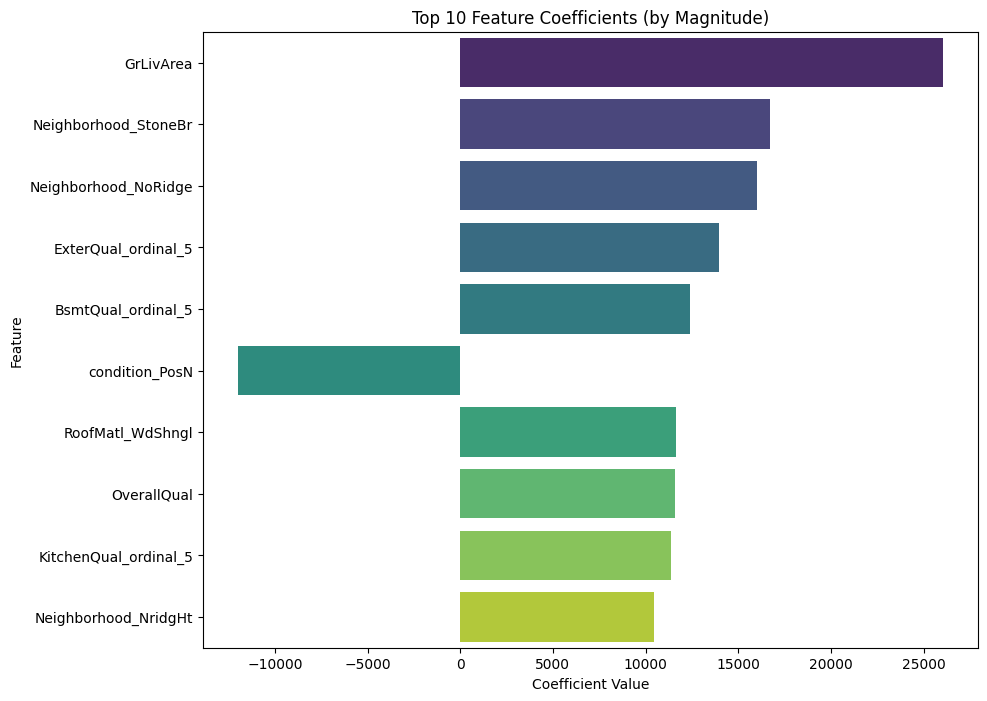

In [75]:
# Plotting feature importance
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Coefficient', y='Feature', 
    data=coefficients_df.head(10), 
    palette='viridis',
    hue = 'Feature',
    legend = False
)
plt.title('Top 10 Feature Coefficients (by Magnitude)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

## Model Evaluation

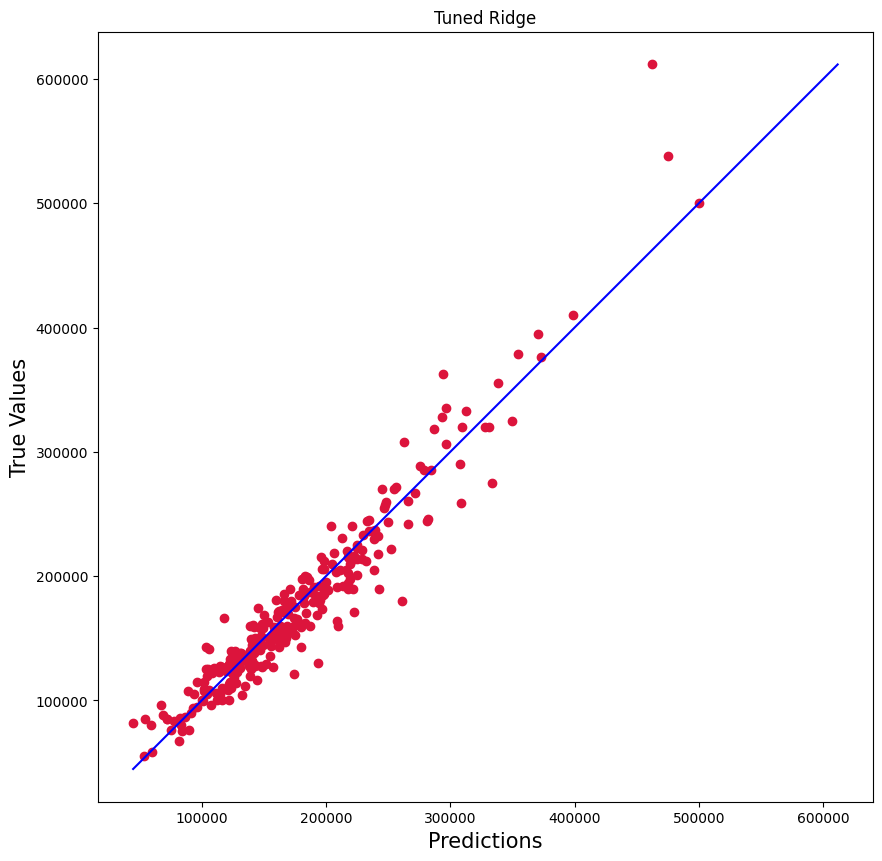

In [76]:
# Plot y_test vs y_test_pred

plt.figure(figsize=(10,10))
plt.scatter(y_test_pred, y_test, c='crimson')

plt.title('Tuned Ridge')
p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Predictions', fontsize=15)
plt.ylabel('True Values', fontsize=15)
plt.axis('equal')
plt.show()

### Residual Plot
- After training your final CatBoost model and using it to make predictions on the test set, you can generate a residual plot to visually inspect its performance. This type of plot is a valuable tool for understanding if your model's errors are random or if there are systematic patterns.

- The plot below shows the relationship between your model's predicted values and the residuals (the difference between the actual and predicted values).

- An ideal residual plot will show a random, uniform scatter of points around the horizontal line at y=0. This indicates that your model's errors are random and are not related to the predicted value. It means your model is not systematically over- or under-predicting for certain ranges of house prices.

- In contrast, if you see a discernible pattern in the plot (e.g., a fanning-out shape, a curve, or a clear concentration of points), it suggests that your model may have a bias. For example, a fanning-out pattern could mean that the model's errors increase as the predicted price gets higher, indicating a need for a more complex model or additional features to handle higher-priced homes.

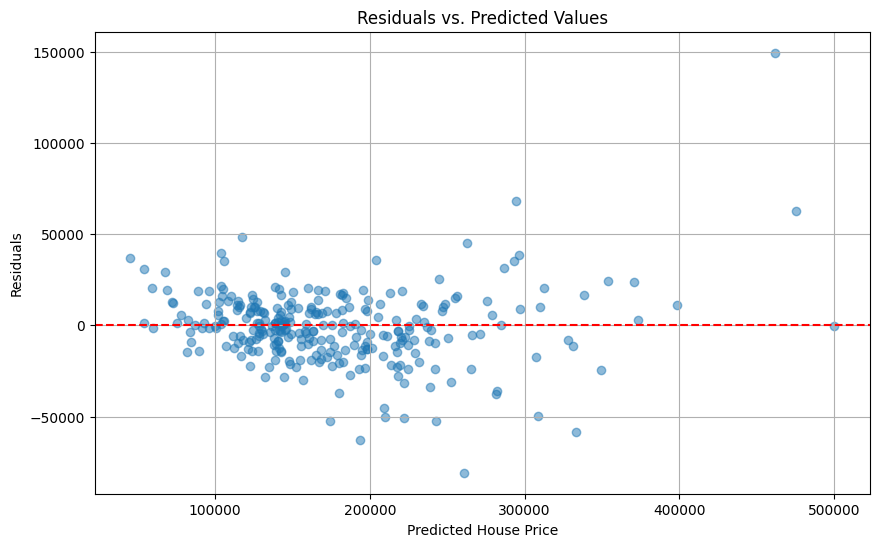

In [77]:
# Plot Residuals vs. Predicted Values

residuals = y_test - y_test_pred

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted House Price')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig('residuals_plot.png')

#print("Residuals plot has been generated and saved as 'residuals_plot.png'.")

### Distribution of actual house prices, y_test and y_test_pred
- Overlap: The more the two distributions overlap, the better your model's predictions align with the actual values. An ideal model's y_pred distribution will closely mimic the y_test distribution.

- Shape: The shapes of the two distributions should be similar. If the y_pred distribution is much narrower than the y_test distribution, it means your model is under-predicting the range of prices and is not confident in making predictions for the highest or lowest-priced homes.

- Skewness: If the actual data is skewed (e.g., towards higher prices), your predicted data should show a similar skew.

In [78]:
# Calculate the mean and standard deviation
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
y_test_pred_mean = np.mean(y_test_pred)
y_test_pred_std = np.std(y_test_pred)

print("Actual Values (y_test) statistics:")
print(f"Mean: {y_test_mean:.4f}")
print(f"Standard Deviation: {y_test_std:.4f}")
print("\nPredicted Values (y_test_pred) statistics:")
print(f"Mean: {y_test_pred_mean:.4f}")
print(f"Standard Deviation: {y_test_pred_std:.4f}")

Actual Values (y_test) statistics:
Mean: 174699.6007
Standard Deviation: 74329.6605

Predicted Values (y_test_pred) statistics:
Mean: 175739.1780
Standard Deviation: 70819.3433


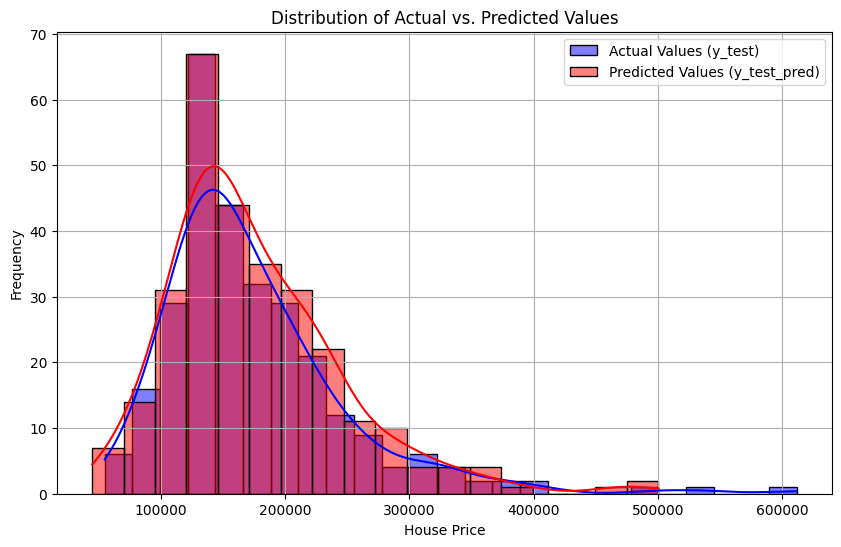

In [79]:
# Plot the distributions of y_test and y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Actual Values (y_test)')
sns.histplot(y_test_pred, kde=True, color='red', label='Predicted Values (y_test_pred)')
#sns.histplot(y, kde=True, color='orange', label='Sales Prices (y)')

plt.title('Distribution of Actual vs. Predicted Values')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
#plt.savefig('distribution_plot.png')

#print("Distribution plot has been generated and saved as 'distribution_plot.png'.")

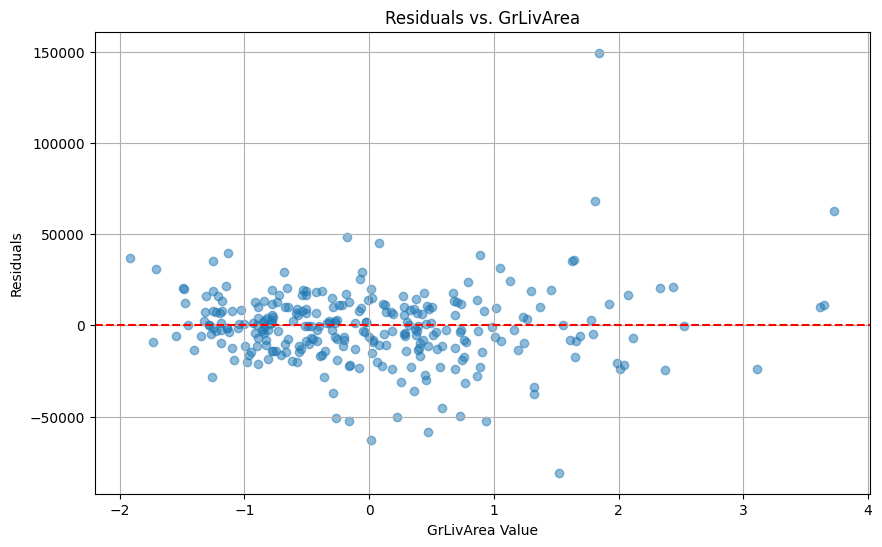

In [80]:
# plot residual vs features

# Choose the feature you want to plot against
feature_to_plot = 'GrLivArea'  # Change this to your desired feature (e.g., 'GrLivArea')
feature_values = X_test[feature_to_plot]

# Create the scatter plot of residuals vs. a chosen feature
plt.figure(figsize=(10, 6))
plt.scatter(feature_values, residuals, alpha=0.5)
plt.title(f'Residuals vs. {feature_to_plot}')
plt.xlabel(f'{feature_to_plot} Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
#plt.savefig(f'residuals_vs_{feature_to_plot}.png')

#print(f"Residuals vs. {feature_to_plot} plot has been generated and saved.")

## Model Explainability

### SHAP
- A SHAP value tells you how much a particular feature pushes the model’s predicted house price up or down, compared to the average prediction across the dataset.

In [37]:
# Say the average predicted price is $200,000
# If for House A, the SHAP value for GrLivArea is +15,000, 
# that means the model believes the GrLivArea of House A contributes +$15,000 to the price, 
# compared to the average. If for House B, the SHAP value is -5,000, 
# that means the GrLivArea of House B is lowering the prediction by $5,000 from the average.

In [81]:
import shap

# Fit explainer on train data
explainer = shap.Explainer(final_model, X_train)

# Evaluate SHAP values on test set
shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [39]:
#import shap

#Fit explainer on train data
#explainer = shap.LinearExplainer(final_model, X_train)

#Evaluate SHAP values on test set
#shap_values = explainer.shap_values(X_test)

#This balances accurate attribution with realistic performance evaluation.

In [82]:
# SHAP feature importance
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for easier viewing and sorting
shap_importance = pd.DataFrame({
    'feature': X.columns,
    'mean_abs_shap_ridge_5fk': mean_abs_shap_values
})

# Sort in descending order
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap_ridge_5fk', ascending=False)

# Display
print(shap_importance_sorted.head(30))

# how to interpret:
# # On average, the feature OverallQual changes the model’s prediction by 14,566 units of currency (likely dollars), 
# either increasing or decreasing the predicted house price.

                    feature  mean_abs_shap_ridge_5fk
0                 GrLivArea             21407.970006
3               OverallQual              9205.811997
24              age_at_sale              7159.133824
6               TotalBsmtSF              7155.583513
4               OverallCond              4901.859691
5                MasVnrArea              4889.472541
14               Fireplaces              4564.266189
62       BsmtQual_ordinal_4              4051.347266
85      ExterQual_ordinal_3              3876.175678
7              BsmtFullBath              3846.287691
57    KitchenQual_ordinal_3              2959.011243
16               GarageArea              2744.738816
61       BsmtQual_ordinal_3              2692.318826
11             BedroomAbvGr              2658.043524
69   BsmtExposure_ordinal_1              2584.511861
232      MasVnrType_BrkFace              2520.423299
15               GarageCars              2445.459874
10                 HalfBath              2356.

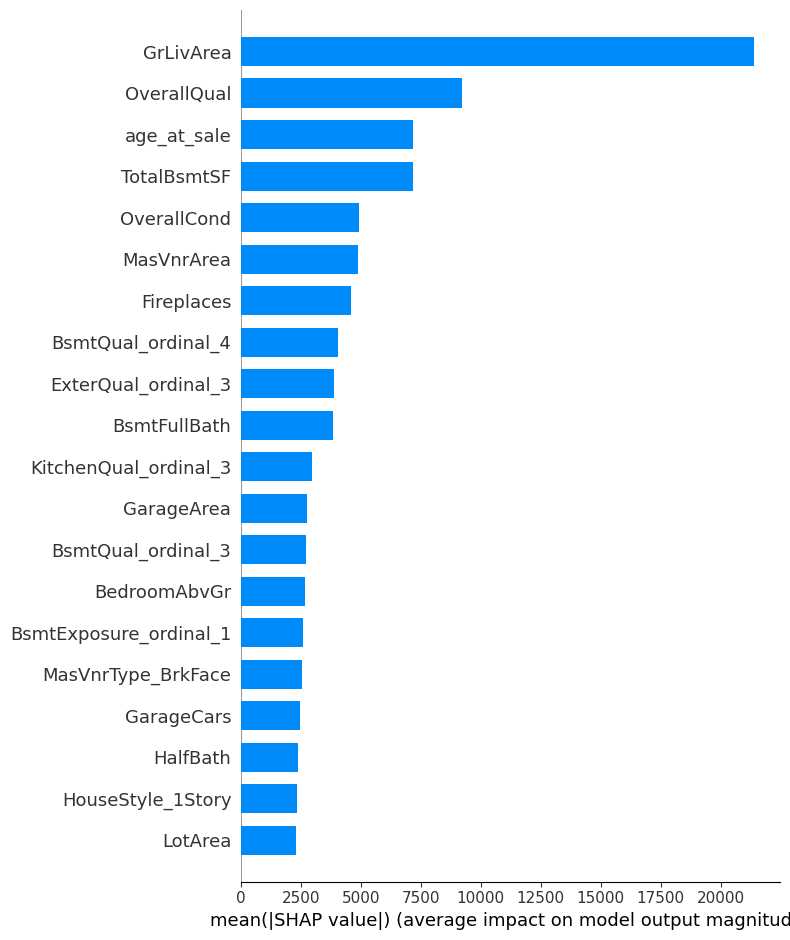

In [83]:
# to visualize the mean abs of SHAP value using summary bar plot
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [42]:
# 1) Verify there are no non-numeric columns
# non_numeric_train = X_train.select_dtypes(exclude=[np.number]).columns.tolist() \
#     if isinstance(X_train, pd.DataFrame) else []
# non_numeric_test  = X_test.select_dtypes(exclude=[np.number]).columns.tolist() \
#     if isinstance(X_test, pd.DataFrame) else []

# print("Non-numeric in TRAIN:", non_numeric_train)
# print("Non-numeric in TEST :", non_numeric_test)

In [84]:
# bool values in X_test has to be converted into int for shap.summary_plot to work
bool_cols_ = X_test.select_dtypes(include="bool").columns.tolist()
X_test[bool_cols_] = X_test[bool_cols_].astype(int)

#shap.summary_plot(shap_values, X_test)

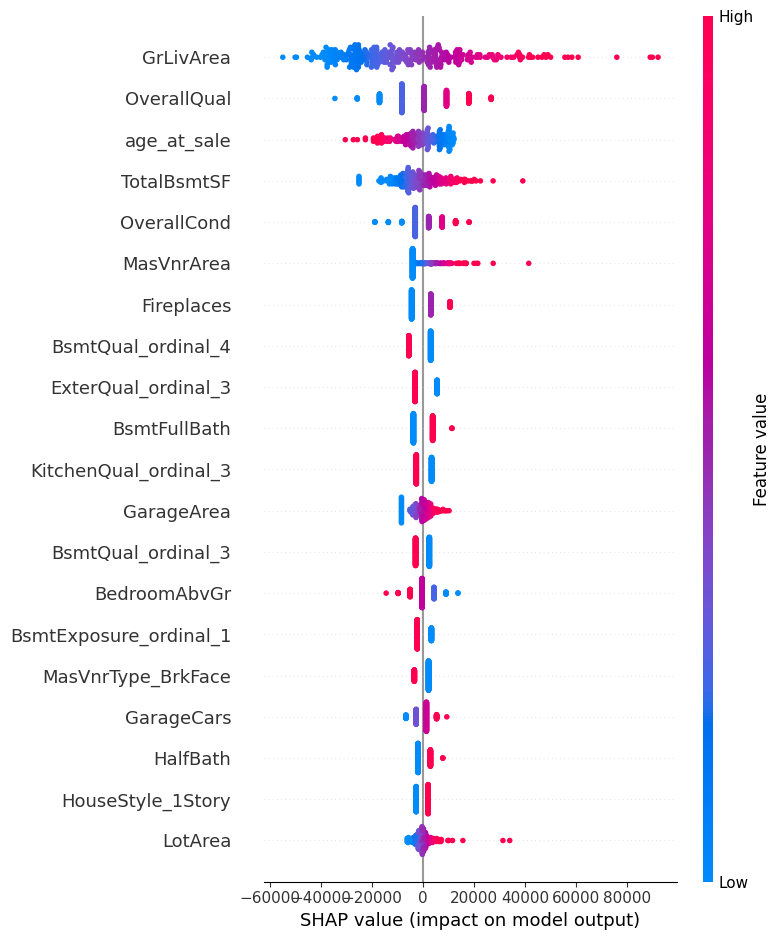

In [85]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# How to Read the Violin Plot
# ✅ 1. Width of the Violin (Horizontal Spread)

# Wider areas indicate more data points with similar SHAP values.

# This shows the distribution of how much that feature affects predictions across your dataset.

# ✅ 2. Color Gradient (Red → Blue)

# Each dot is colored by the actual value of the feature:

# Red = High feature value

# Blue = Low feature value

# This helps you understand the direction of the effect.

# For example, if red dots are mostly on the right (positive SHAP values), high values of that feature increase the prediction (e.g., higher price).

# If blue dots are on the left (negative SHAP values), low values decrease the prediction.

# ✅ 3. X-Axis (SHAP Value)

# Represents the magnitude and direction of impact on the model’s prediction.

# A value of +5000 means the feature adds $5,000 (for a house price model).

# A value of -3000 means it subtracts $3,000 from the prediction.

### SHAP Dependence Plot
- In a SHAP dependence plot, the x-axis shows the value of the feature you specified, and the y-axis shows the SHAP value (i.e., the feature’s contribution to the model output). But if you’re seeing a second feature encoded on the plot, that’s expected and by design. The second feature (by color) is there to show interactions. The SHAP dependence plot automatically colors the points by the most correlated feature with the one on the x-axis. This helps uncover interactions between features.

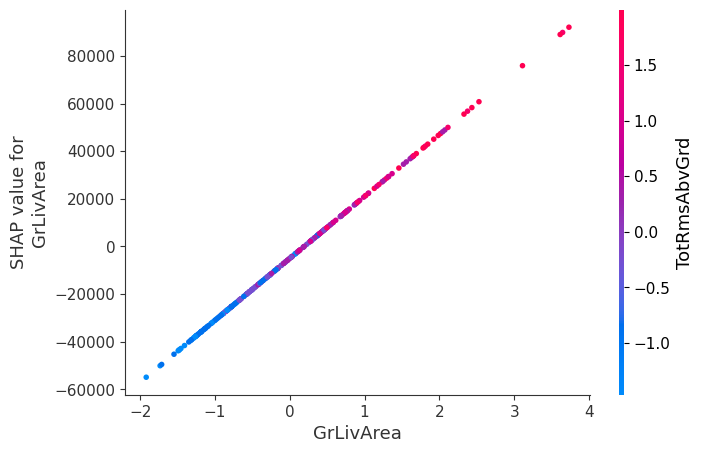

In [86]:
shap.dependence_plot('GrLivArea', shap_values, X_test)

# if don't want to show the second y-axis
#shap.dependence_plot('GrLivArea', shap_values, x_test, interaction_index=None)

<Figure size 600x400 with 0 Axes>

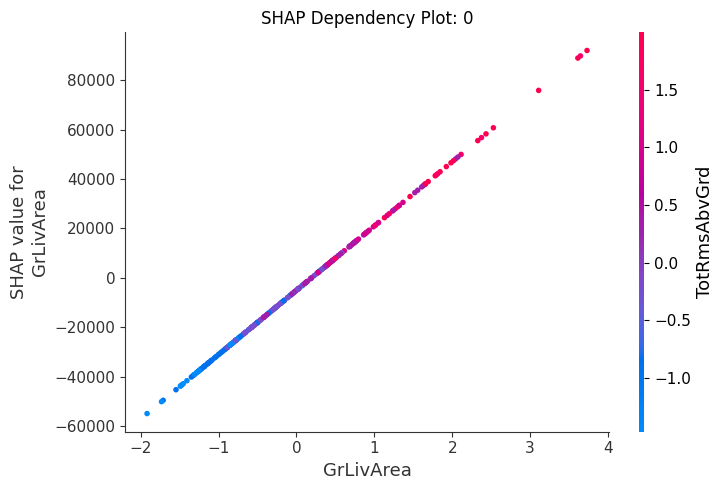

<Figure size 600x400 with 0 Axes>

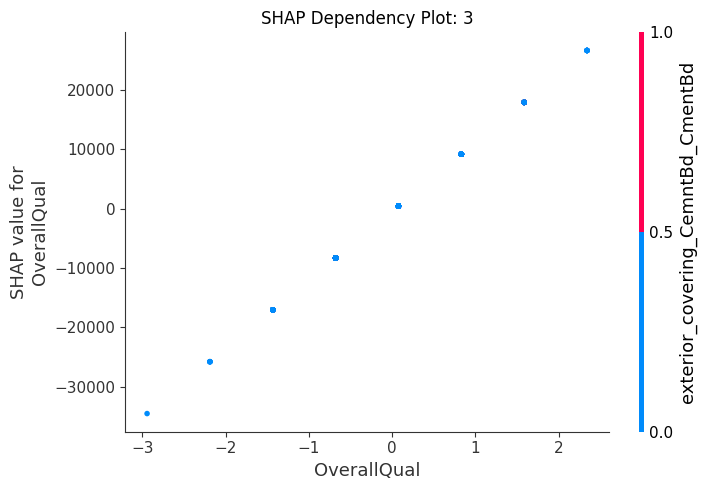

<Figure size 600x400 with 0 Axes>

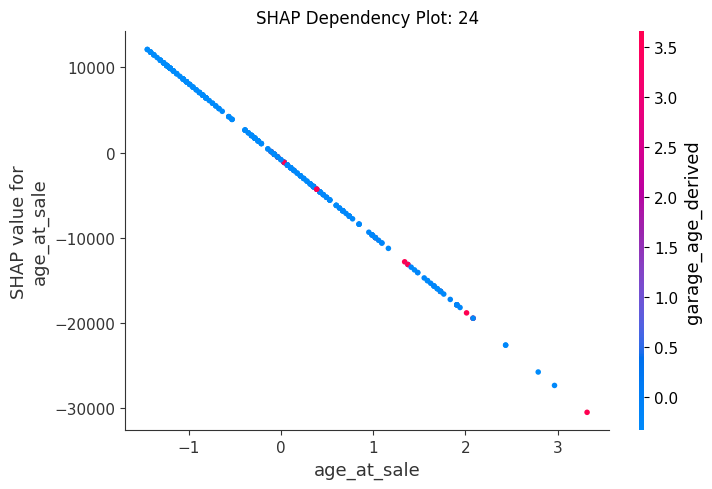

<Figure size 600x400 with 0 Axes>

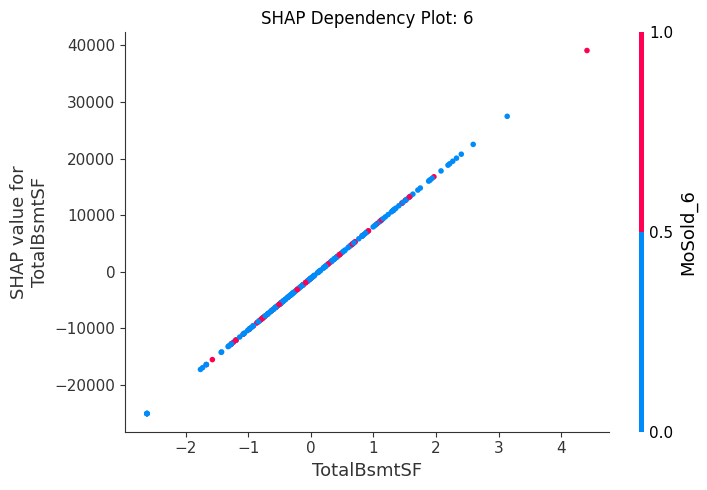

<Figure size 600x400 with 0 Axes>

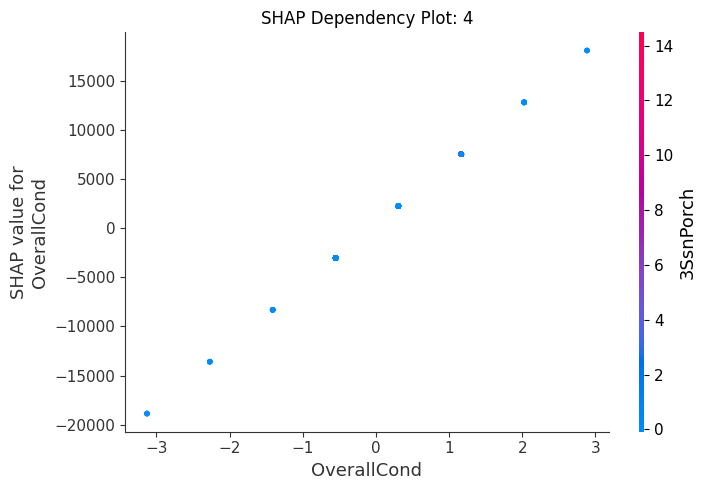

<Figure size 600x400 with 0 Axes>

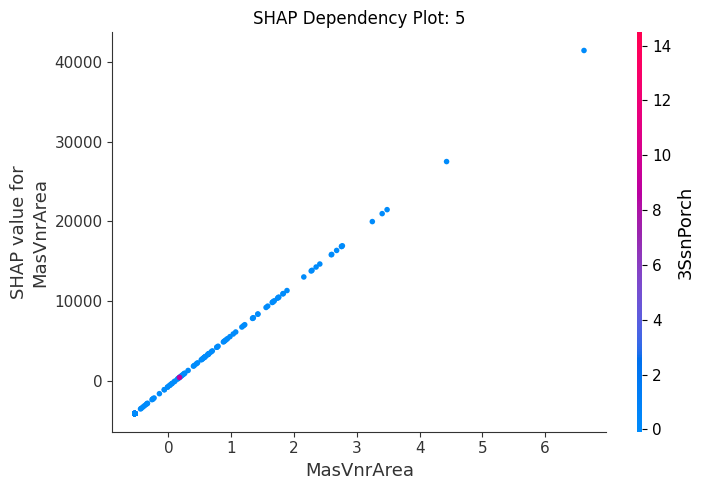

<Figure size 600x400 with 0 Axes>

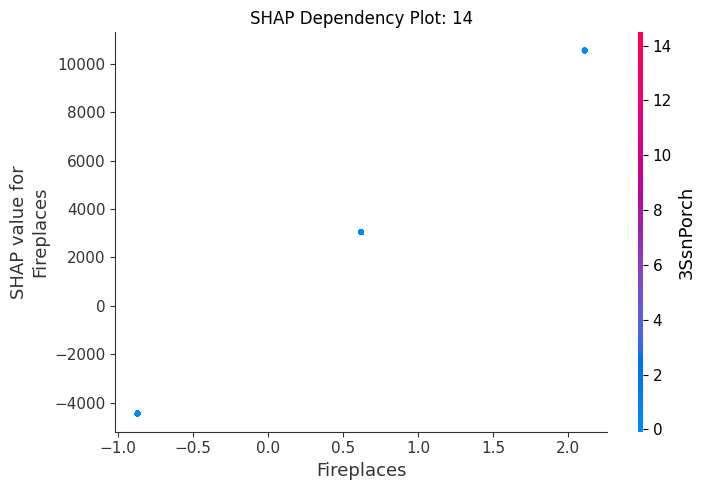

<Figure size 600x400 with 0 Axes>

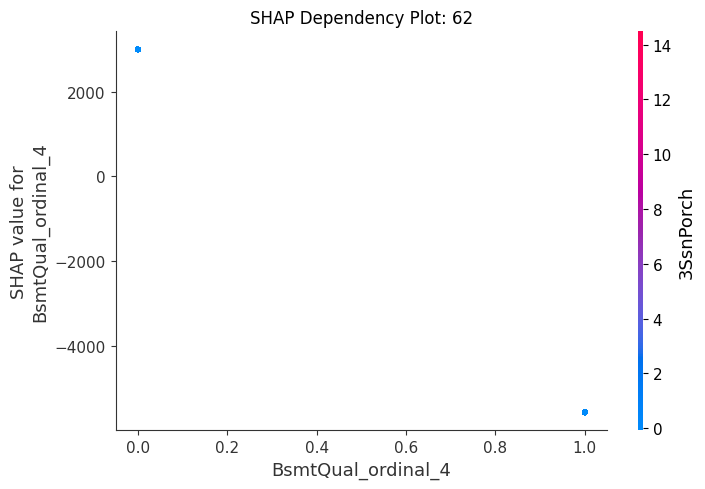

<Figure size 600x400 with 0 Axes>

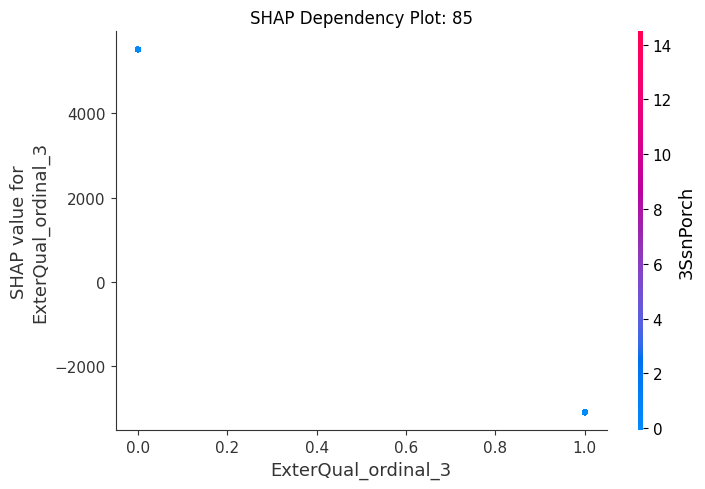

<Figure size 600x400 with 0 Axes>

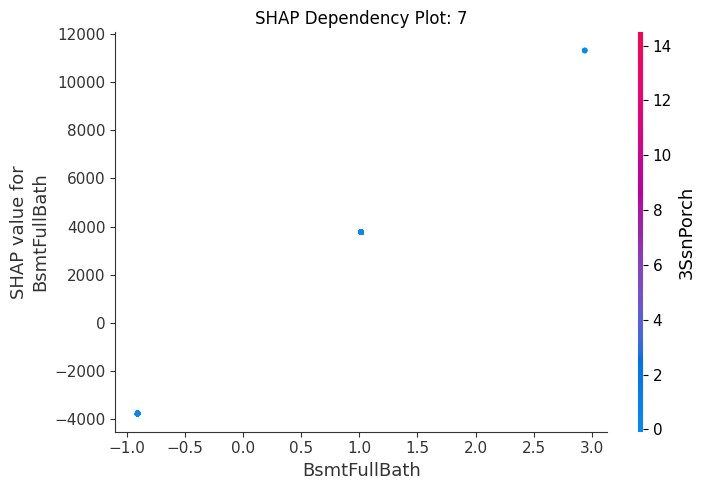

<Figure size 600x400 with 0 Axes>

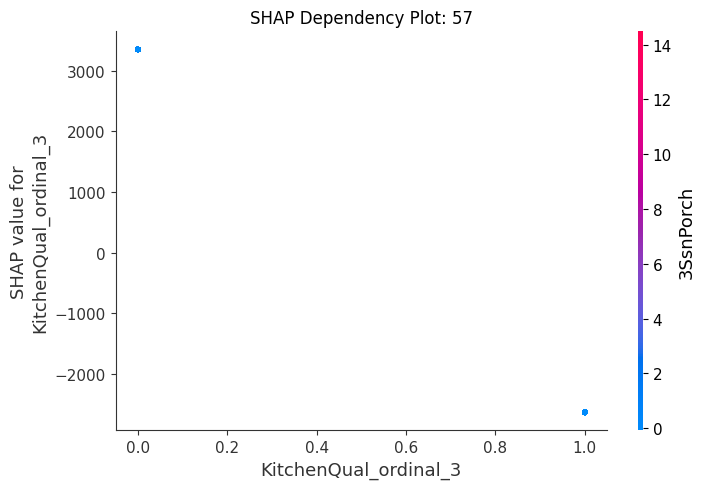

<Figure size 600x400 with 0 Axes>

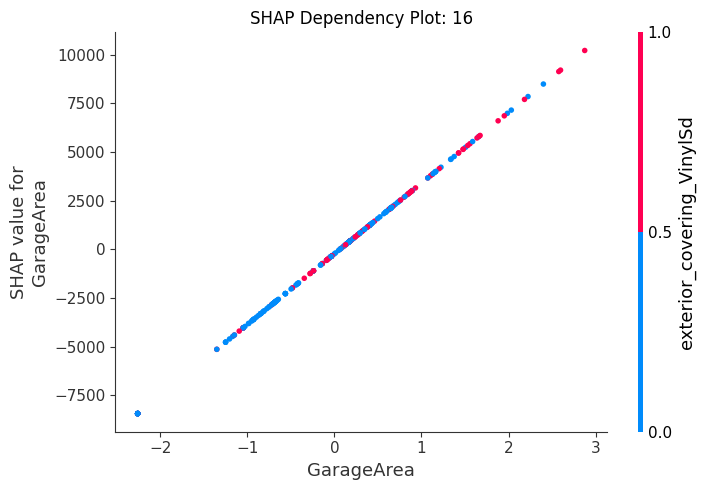

<Figure size 600x400 with 0 Axes>

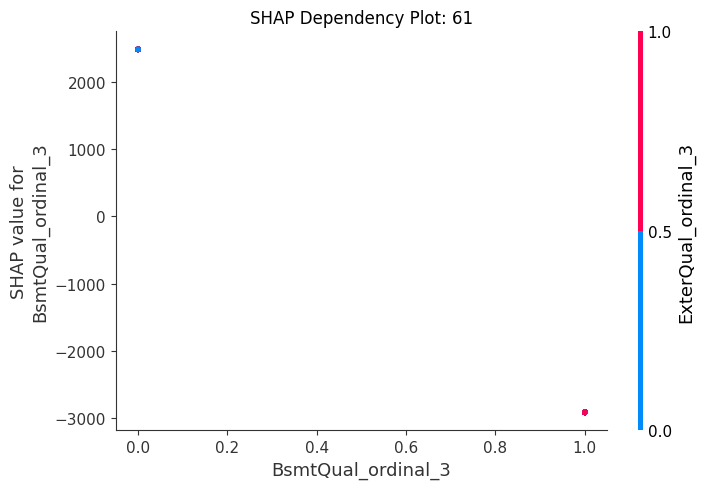

<Figure size 600x400 with 0 Axes>

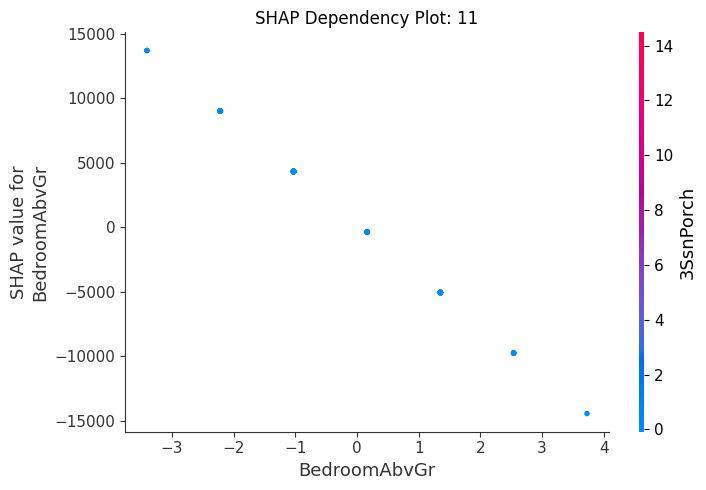

<Figure size 600x400 with 0 Axes>

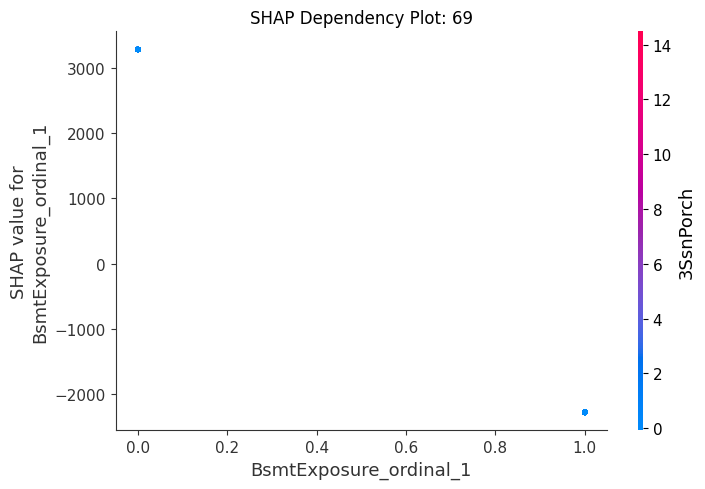

<Figure size 600x400 with 0 Axes>

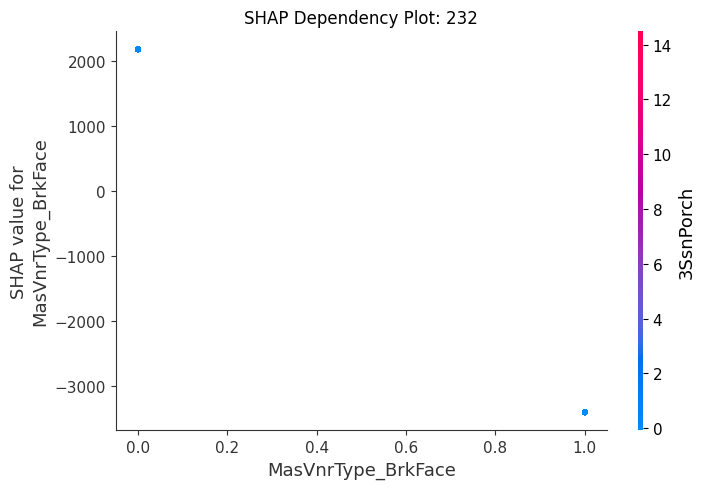

<Figure size 600x400 with 0 Axes>

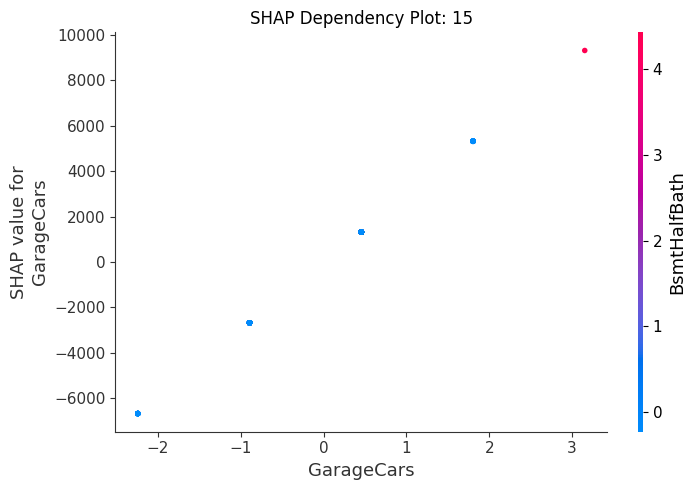

<Figure size 600x400 with 0 Axes>

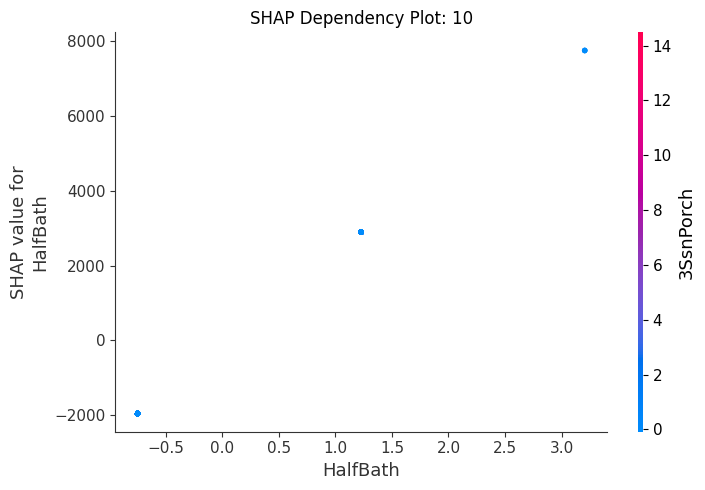

<Figure size 600x400 with 0 Axes>

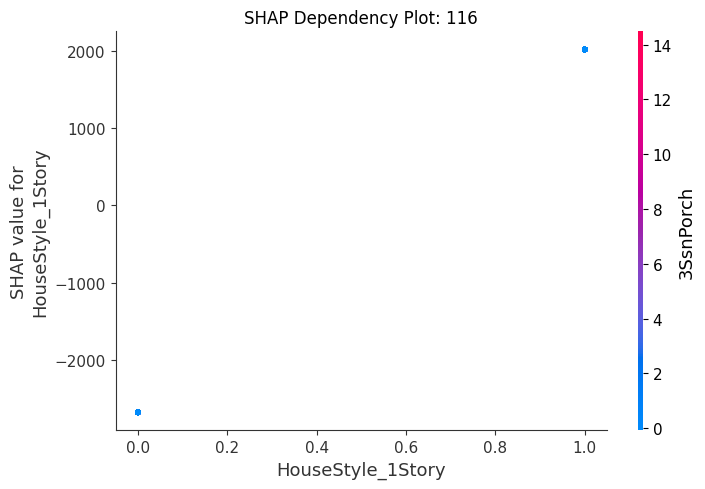

<Figure size 600x400 with 0 Axes>

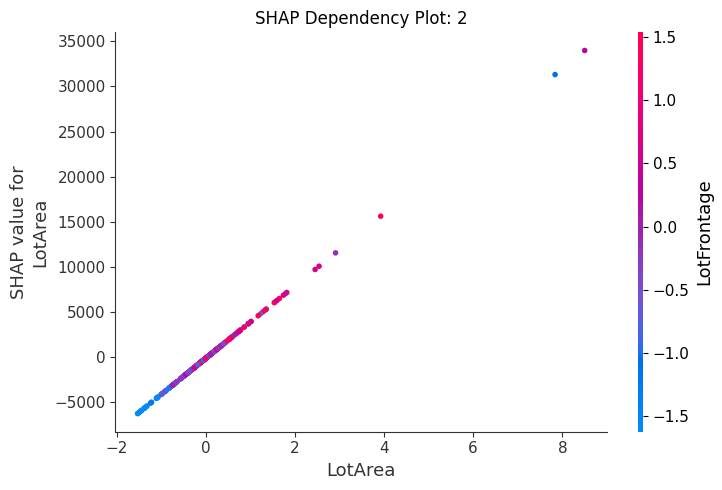

In [87]:
# Select top 20 features
top_features = shap_importance_sorted.head(20).index.tolist()

for feature in top_features:
    plt.figure(figsize=(6, 4))  # Compact size
    
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        #interaction_index=None,  # Auto-picks a good feature for color encoding
        show=False
    )
    plt.title(f"SHAP Dependency Plot: {feature}")
    plt.tight_layout()
    plt.show()
    
    # Save plot to file
#     filename = f"shap_dependency_{feature}.png"
#     plt.savefig(filename, dpi=150)
#     plt.close()

# how to interpret
# using OverallQual as an example,
# 1stFlrSF is the most correlated feature with Overall
# you can see larger homes with high OverallQual have even higher SHAP values (strong positive synergy).
# Conversely, small homes (blue dots) with high OverallQual may still not be valued as highly.

### Export lists for final model comparison

In [88]:
shap_importance_sorted

,feature,mean_abs_shap_ridge_5fk
0,GrLivArea,21407.970006
3,OverallQual,9205.811997
24,age_at_sale,7159.133824
6,TotalBsmtSF,7155.583513
4,OverallCond,4901.859691
...,...,...
197,exterior_covering_Plywood_ImStucc,0.000000
195,exterior_covering_Plywood_CBlock,0.000000
192,exterior_covering_MetalSd_Wd Shng,0.000000
191,exterior_covering_MetalSd_Wd Sdng,0.000000


In [89]:
# export SHAP importance data into a csv
shap_importance_sorted.reset_index(inplace=True)
shap_importance_sorted.to_csv('shap_importance_ridge.csv', index=False)

In [90]:
# Create a new DataFrame that includes the best value from the tuning process as well.
# This addresses the user's specific request.
full_comparison = pd.DataFrame({
    'model': ['Ridge'] * 3,
    'metric': ['Test_R2', 'Best_Tuned_R2', 'Final_CV_mean_R2'],
    'score': [r2_5kf_test, study.best_value, cv_r2_mean]
})

In [91]:
full_comparison

,model,metric,score
0,Ridge,Test_R2,0.922104
1,Ridge,Best_Tuned_R2,0.929130
2,Ridge,Final_CV_mean_R2,0.907283


In [92]:
# export R2 scores into a csv
full_comparison.reset_index(inplace=True)
full_comparison.to_csv('r2_ridge.csv', index=False)

### Extract the list of features and features that each one is most correlated with

In [93]:
# Compute correlation matrix for SHAP dependency plot coloring
cor_matrix = X_test.corr()

In [94]:
most_correlated = {}

for feature in X_test.columns:
    # Exclude self-correlation
    corrs = cor_matrix[feature].drop(labels=[feature])
    
    # Drop NaNs
    corrs = corrs.dropna()
    
    # Get feature with highest absolute correlation
    if not corrs.empty:
        most_correlated_feature = corrs.abs().idxmax()
        most_correlated[feature] = most_correlated_feature

In [95]:
correlation_df = pd.DataFrame.from_dict(most_correlated, orient='index', columns=['Most_Correlated_Feature'])
correlation_df.reset_index(inplace=True)
correlation_df.columns = ['feature', 'most_correlated_feature_ridge_5fk']

In [96]:
correlation_df

,feature,most_correlated_feature_ridge_5fk
0,GrLivArea,TotRmsAbvGrd
1,LotFrontage,LotArea
2,LotArea,exterior_covering_CemntBd_Wd Shng
3,OverallQual,ExterQual_ordinal_3
4,OverallCond,ExterCond_ordinal_4
...,...,...
222,MoSold_7,QrtSold_Q3
223,Electrical_FuseF,Electrical_SBrkr
224,Electrical_SBrkr,Electrical_FuseF
225,QrtSold_Q2,MoSold_3


In [97]:
# limit the above list to top 20 features ranked by mean abs SHAP values
ridge_SHAP_feature_final = pd.merge(
    shap_importance_sorted, 
    correlation_df, 
    how='left',
    on = 'feature'
)

ridge_SHAP_feature_final

,index,feature,mean_abs_shap_ridge_5fk,most_correlated_feature_ridge_5fk
0,0,GrLivArea,21407.970006,TotRmsAbvGrd
1,3,OverallQual,9205.811997,ExterQual_ordinal_3
2,24,age_at_sale,7159.133824,GarageType_Detchd
3,6,TotalBsmtSF,7155.583513,OverallQual
4,4,OverallCond,4901.859691,ExterCond_ordinal_4
...,...,...,...,...
320,197,exterior_covering_Plywood_ImStucc,0.000000,NaN
321,195,exterior_covering_Plywood_CBlock,0.000000,RoofMatl_Tar&Grv
322,192,exterior_covering_MetalSd_Wd Shng,0.000000,RoofStyle_Mansard
323,191,exterior_covering_MetalSd_Wd Sdng,0.000000,NaN
